### Community Detection Algorithm

We build a graph for all pixels, and use community discover method for cluster. 

Steps are as follows:
1. Build Graph
2. Demo of several discover algorithm


NOTE that in graph, physical distance is ignored, unless you set distance in metrix.
____

In [1]:
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import pandas as pd
from Brain_Atlas.Atlas_Mask import Mask_Generator
from Atlas_Corr_Tools import *
from scipy.stats import pearsonr
from Signal_Functions.Pattern_Tools import Do_PCA
import time

wp = r'D:\_DataTemp\OIS\Wild_Type\Preprocessed'

# use 1D vector to build graph
on_response,on_mask = cf.Load_Variable(wp,'Response_1d.pkl')

___
- ##### Step 1: Build graph.    
Provide distance matrix for graph build, Distance matrix can be build directly using kneighbor_graph.

Higher neighbor will focus on global info, and less neighbor are more local.    
*Here I show 2 different neighbors, they response differently.*

In [2]:
from sklearn.neighbors import kneighbors_graph
import networkx as nx

# standarize matrix
normalized_ts = (on_response - on_response.mean(axis=1, keepdims=True))/on_response.std(axis=1, keepdims=True)

# define k value, indicating graph build parameter.
k_l = 30
k_h = 80

# use sklearn function can generate adjacency matrix directly,
adjacency_l = kneighbors_graph(normalized_ts,n_neighbors=k_l,mode='connectivity',metric='l2',include_self=False)
adjacency_h = kneighbors_graph(normalized_ts,n_neighbors=k_h,mode='connectivity',metric='l2',include_self=False)
# symetry the matrix
adjacency_l = (adjacency_l + adjacency_l.T) / 2 
adjacency_h = (adjacency_h + adjacency_h.T) / 2 


You can visualize adjacency matrix's difference. Bigger N means denser connection.

Text(0.5, 1.0, 'N=80')

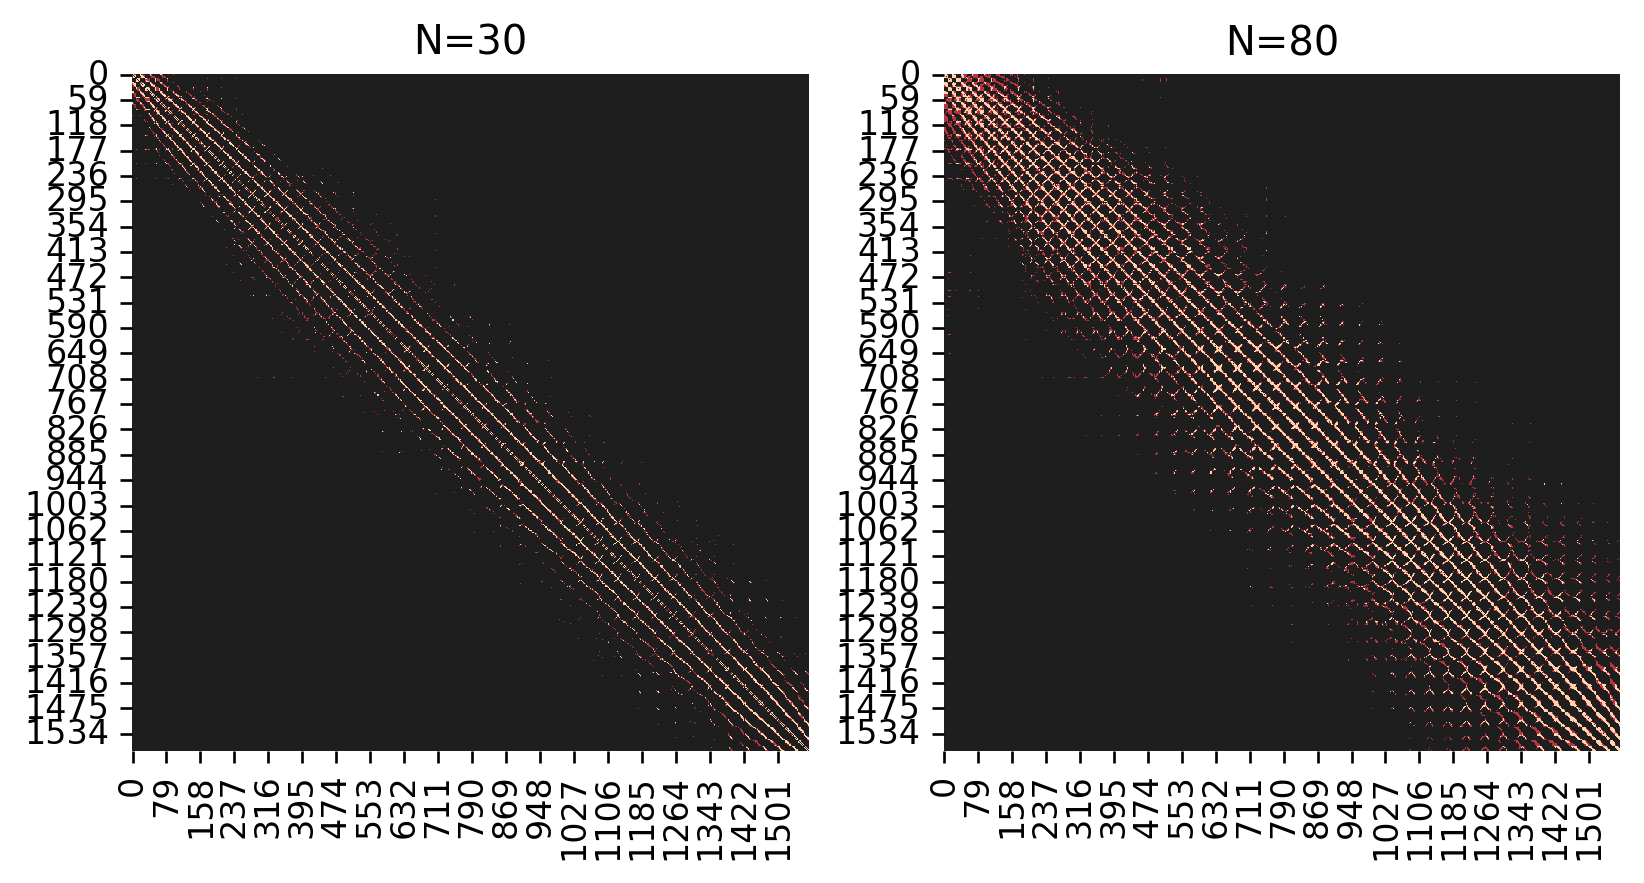

In [3]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (8,5),dpi=240)

sns.heatmap(adjacency_l.toarray(),ax = ax[0],center=0,vmax = 1,cbar=False,square=True)
sns.heatmap(adjacency_h.toarray(),ax = ax[1],center=0,vmax = 1,cbar=False,square=True)

ax[0].set_title(f'N={k_l}')
ax[1].set_title(f'N={k_h}')

- Visualize graph of different k.    
Graph is high-dimension manifold, so 2D graph only show us a projection.    
**It's ONLY a visualization, Graph is not changed by this.**

In [4]:
# define plot functions.
import matplotlib.patches as mpatches

def Network_Edge(G,ax,alpha = 0.01,seed = 1066): 
    pos = nx.spring_layout(G,seed=seed) # position of layout,different for each time. # pos is a dict, indicating which nodes' location.
    nx.draw_networkx_edges(G, pos, alpha=alpha,ax = ax)
    return ax

Text(0.5, 1.0, 'N=80')

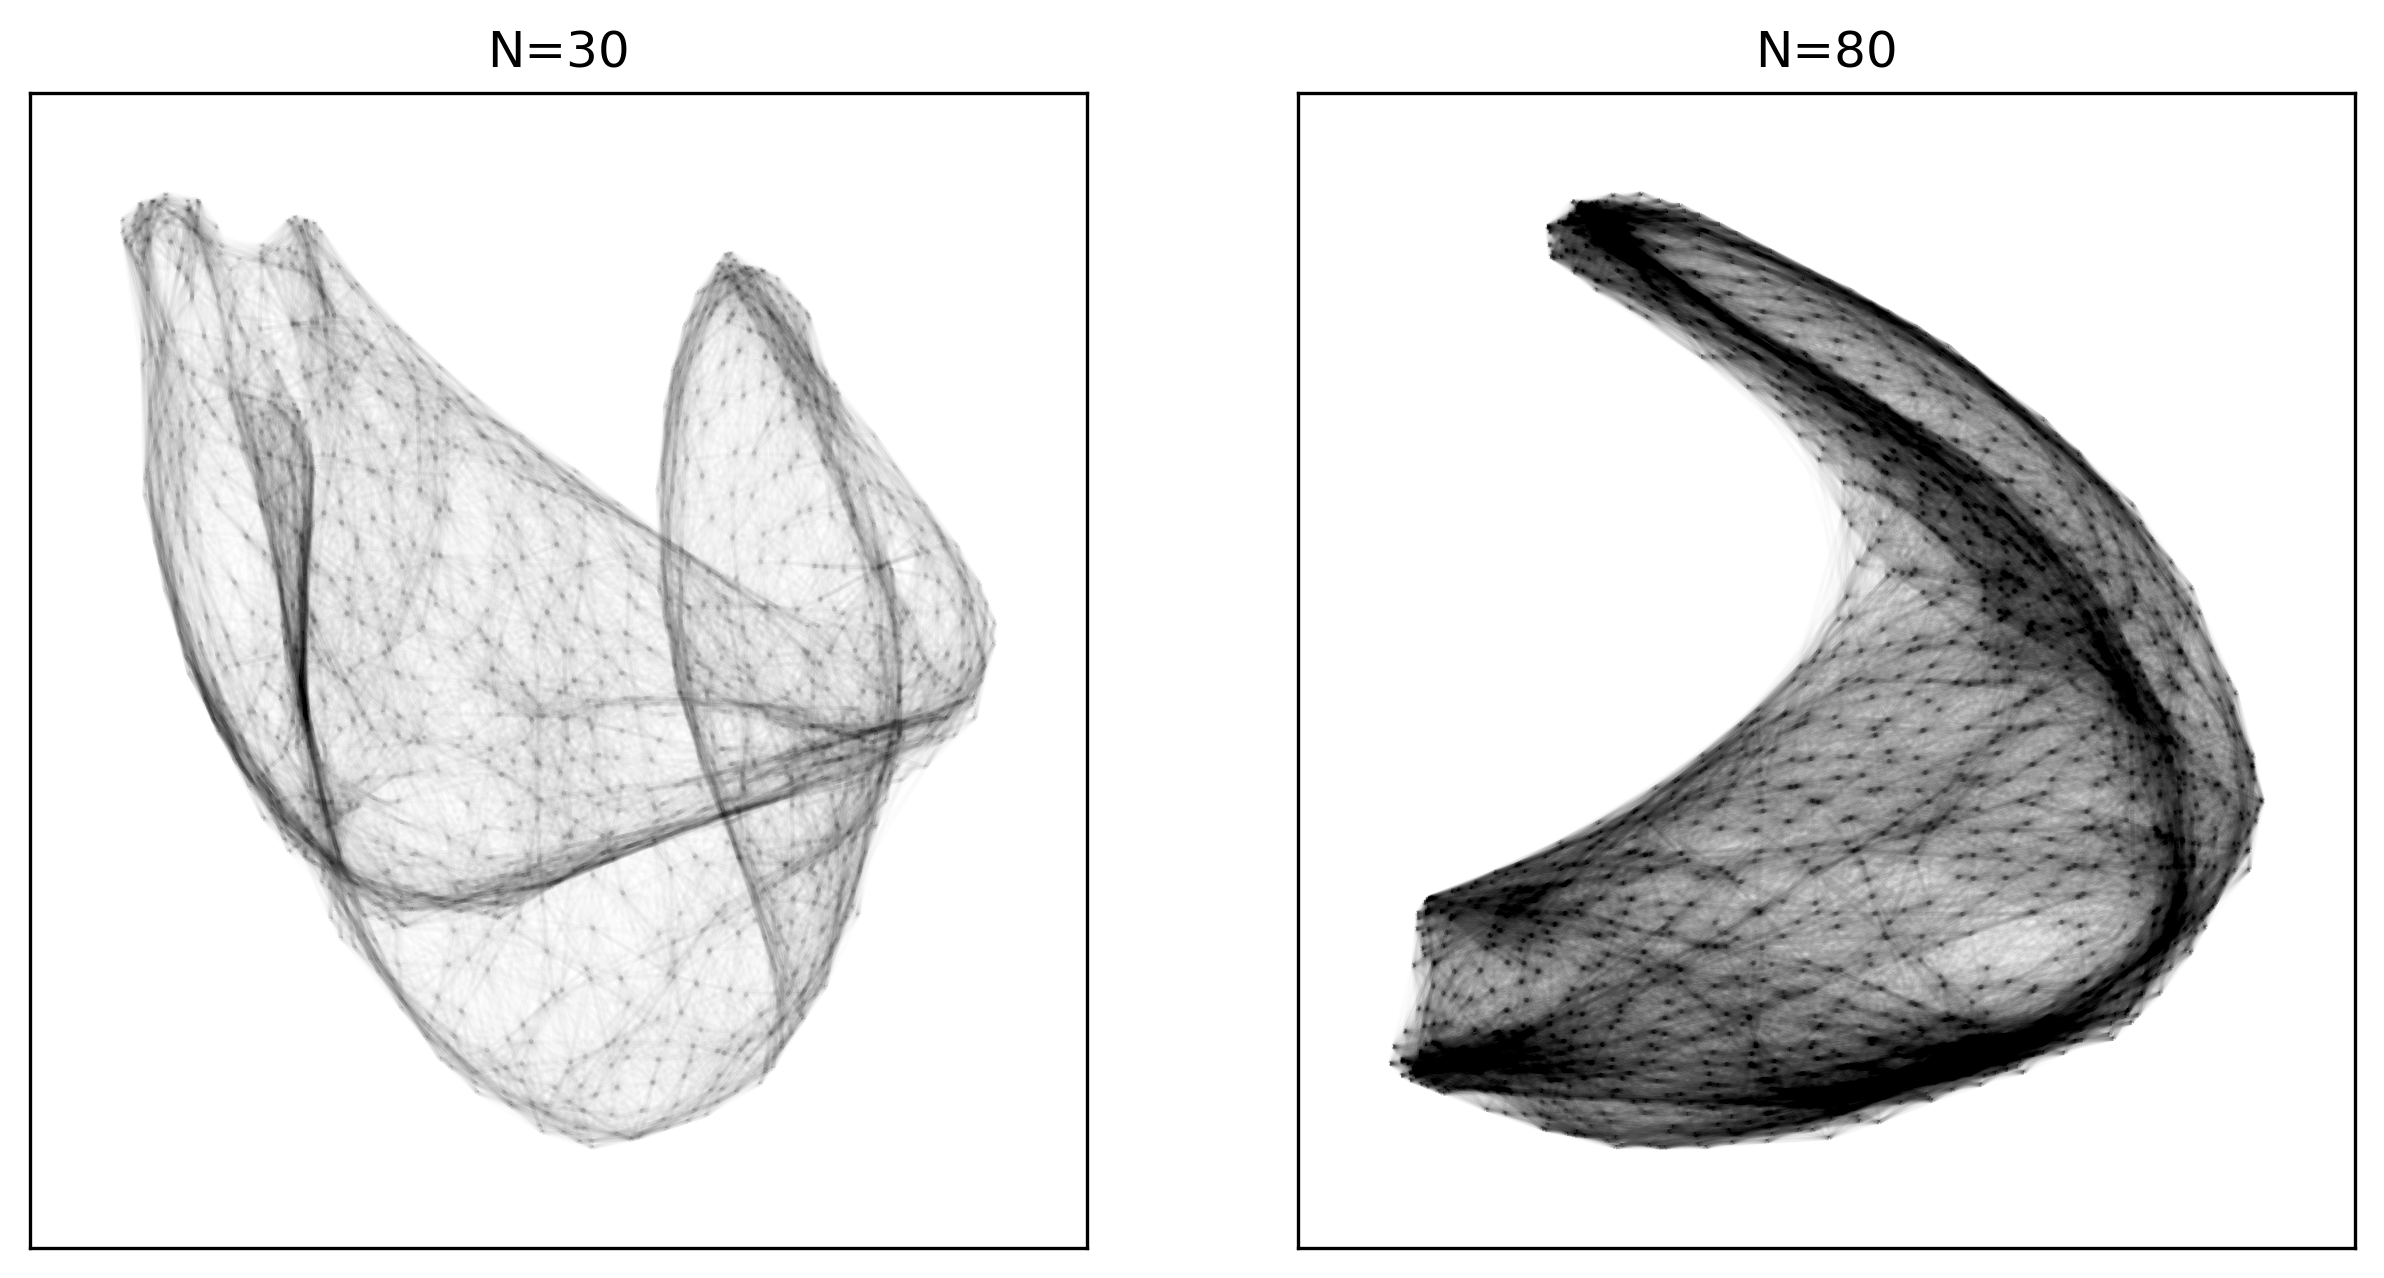

In [17]:
# Build Graph using networkx pkg.
G_l = nx.from_scipy_sparse_array(adjacency_l)
G_h = nx.from_scipy_sparse_array(adjacency_h)

# use Fruchterman-Reingold layout for graph projection.
fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (10,5),dpi = 300)
ax[0] = Network_Edge(G = G_l,ax = ax[0],alpha=0.01,seed=1914)
ax[1] = Network_Edge(G = G_h,ax = ax[1],alpha=0.01,seed=1918)

ax[0].set_title(f'N={k_l}')
ax[1].set_title(f'N={k_h}')



___
- ##### Step2, several demo of graph-based community discovery algorithm.
We will show:    
1. Lovian algorithm
2. Infomap algorithm
3. Label Propagation algorithm

check https://cdlib.readthedocs.io/en/latest/reference/cd_algorithms/node_clustering.html for more methods.   
And feel free to be creative.


- Option A: Lovian algorithm.    
Lovian algorithm works like a k-mean on graph, it try to seperate neighbors as far as possible, and you only need to setup resolution of neighbors.    
This method have a litte random, but variation acceptable.

In [6]:
import community.community_louvain as louvain # install as Python-Louvain,but use as community.

# codes below will show the community of each node, start from 0.
partition_l = louvain.best_partition(G_l, resolution=1) # less resolution is more sensitive to fluctuations.
partition_h = louvain.best_partition(G_h, resolution=1) # less resolution is more sensitive to fluctuations.

# transfer dict into pd frame.
louvian_df_l = pd.DataFrame({'pixel': partition_l.keys(),'community': partition_l.values()}).sort_values(by='pixel')
louvian_df_h = pd.DataFrame({'pixel': partition_h.keys(),'community': partition_h.values()}).sort_values(by='pixel')

# start from community 1, for visualization convinient.
louvian_df_l['community'] += 1
louvian_df_h['community'] += 1


print(f'Low neighbor have {len(set(louvian_df_l['community']))} communities.')
print(f'High neighbor have {len(set(louvian_df_h['community']))} communities.')
louvian_df_l

Low neighbor have 11 communities.
High neighbor have 7 communities.


pixel  community
0         0          5
1         1          5
2         2          5
3         3          5
4         4          5
...     ...        ...
1569   1569         11
1570   1570         11
1571   1571         11
1572   1572         11
1573   1573         11

[1574 rows x 2 columns]

- Then visualize nodes on graph and on real space.

In [7]:
import matplotlib.patches as mpatches

# first show nodes on graph.
def Show_Nodes(G,community_df,ax,alpha = 0.01,seed = 1066):
    colors = community_df['community']

    ## color bar first. Plot color bar in plt is very complex = =
    unique_groups = sorted(set(colors))
    cmap = plt.cm.jet  # Use the same colormap as your nodes
    norm = plt.Normalize(vmin=min(colors)-1, vmax=max(colors))  # Same normalization,keep 0 to remain the same as recover graph.
    # Create legend patches
    legend_patches = [
        mpatches.Patch(color=cmap(norm(group)), label=group)
        for group in unique_groups
    ]
    # Add legend to plot
    ax.legend(handles=legend_patches, title='Groups',prop={'size': 6},title_fontsize=10)


    ## plot node graph and connection graph.
    pos = nx.spring_layout(G,seed=seed) 
    nx.draw_networkx_nodes(G, pos, node_size=2, node_color=colors,edgecolors=None,vmin=0,cmap = cmap,ax = ax) # set vmin to keep jet normalization work.
    nx.draw_networkx_edges(G, pos, alpha=alpha,ax = ax)
    return ax

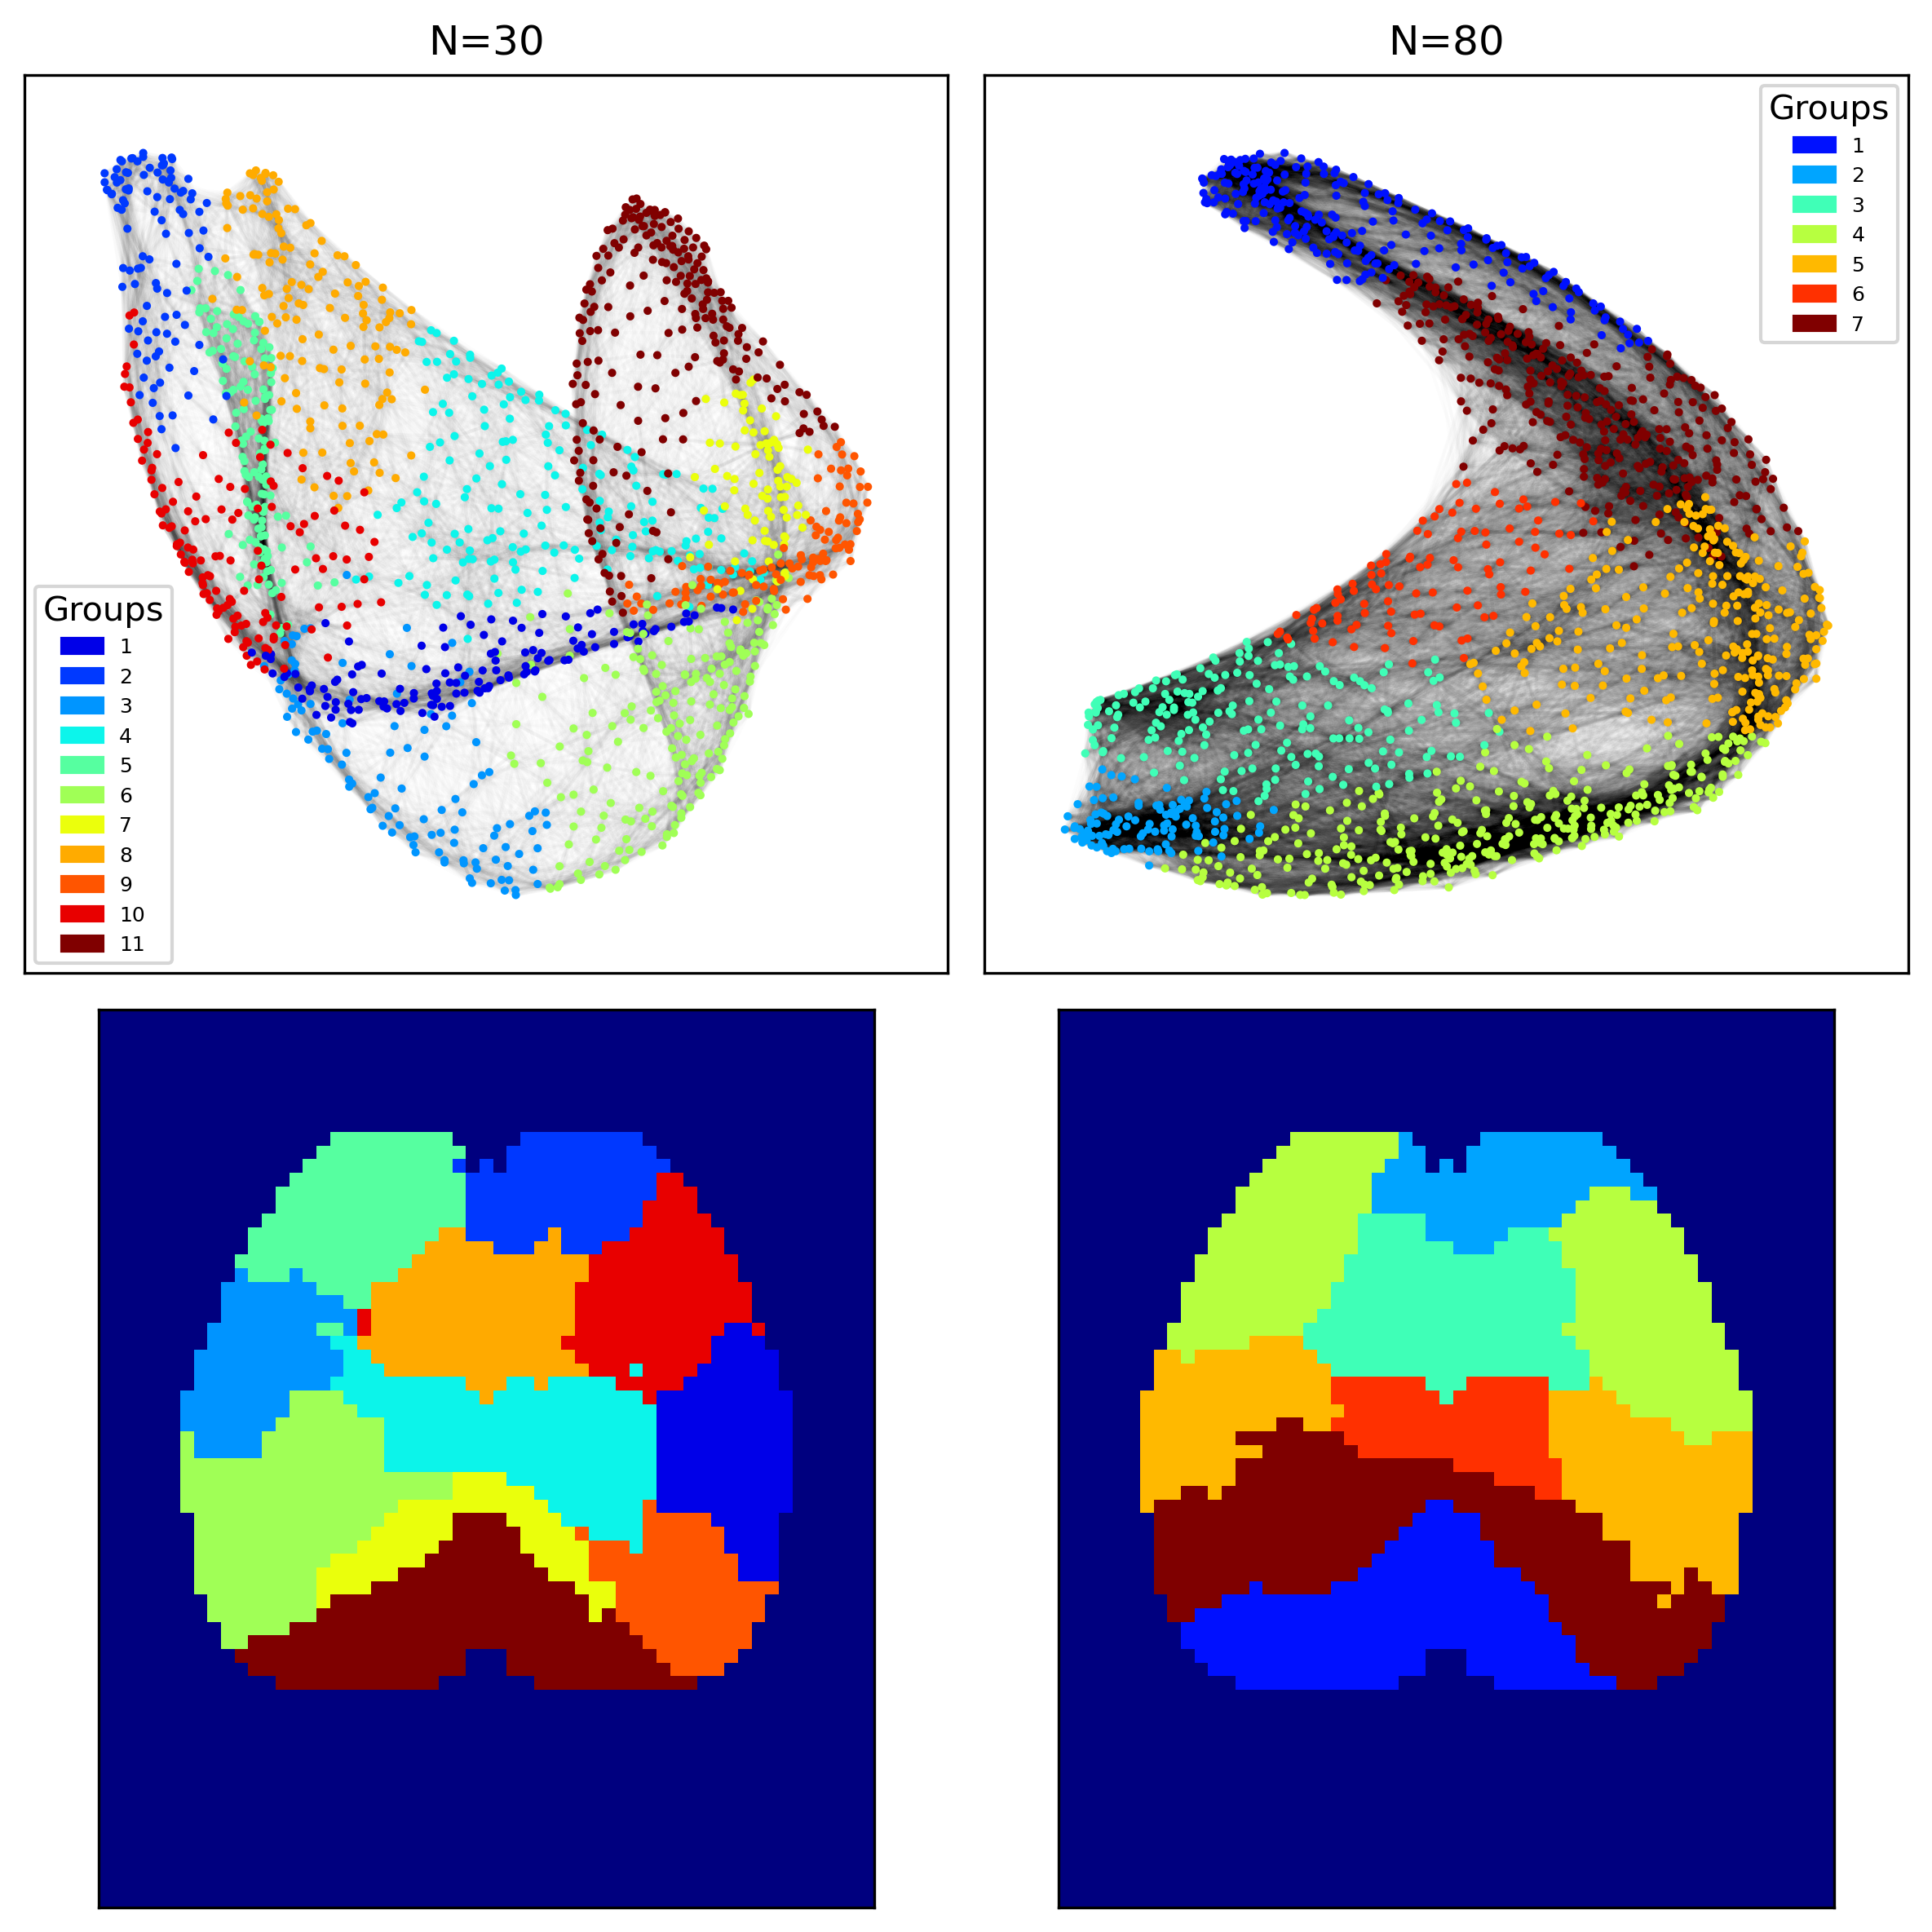

In [18]:
## plot network with louvian-found groups.
fig,ax = plt.subplots(ncols=2,nrows=2,figsize = (8,8),dpi = 300)
ax[0,0] = Show_Nodes(G = G_l,community_df=louvian_df_l,ax = ax[0,0],seed=1914)
ax[0,1] = Show_Nodes(G = G_h,community_df=louvian_df_h,ax = ax[0,1],seed=1918)

ax[0,0].set_title(f'N={k_l}')
ax[0,1].set_title(f'N={k_h}')

## Plot visualized graph. compare node with graph distribution.
def Recover_Community(community,on_mask):
    c_vec = community['community']
    recover = copy.deepcopy(on_mask).astype('i4')
    recover[on_mask==True] = c_vec
    return recover
recover_l = Recover_Community(louvian_df_l,on_mask)
recover_h = Recover_Community(louvian_df_h,on_mask)
# show recovered graphs below
ax[1,0].imshow(recover_l,cmap='jet')
ax[1,1].imshow(recover_h,cmap='jet')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

fig.tight_layout()

##### It works fine!    
You can see that if neighbor is big enough, the network can clust bilateral networks. They do correlate with contralateral, but there are inside preference.    
**If might indicate horizontal connection's effect range. For this case, it's above 30 pix and below 80pix, correspond to 1.2~3.2 mm2.**    

Demo below shows how to find nodes in specific area of one graph.

       pix         X         Y  Community
0        0 -0.258495 -0.695492          4
1        1 -0.281192 -0.686238          4
2        2 -0.278503 -0.688555          4
3        3 -0.276125 -0.679873          4
4        4 -0.275308 -0.668326          4
...    ...       ...       ...        ...
1569  1569 -0.112158  0.784888          1
1570  1570 -0.076454  0.739813          1
1571  1571 -0.039860  0.707750          7
1572  1572 -0.004020  0.660456          7
1573  1573  0.010654  0.641538          7

[1574 rows x 4 columns]


C:\Users\rui_z\AppData\Local\Temp\ipykernel_31568\273899681.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(pos_h_frame[pos_h_frame['X']<0.1][pos_h_frame['Y']<-0.5][pos_h_frame['X']>-0.1],x = 'X',y='Y',color='r',s=50,lw=0,ax = ax)
C:\Users\rui_z\AppData\Local\Temp\ipykernel_31568\273899681.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(pos_h_frame[pos_h_frame['X']<0.1][pos_h_frame['Y']<-0.5][pos_h_frame['X']>-0.1],x = 'X',y='Y',color='r',s=50,lw=0,ax = ax)


<Axes: xlabel='X', ylabel='Y'>

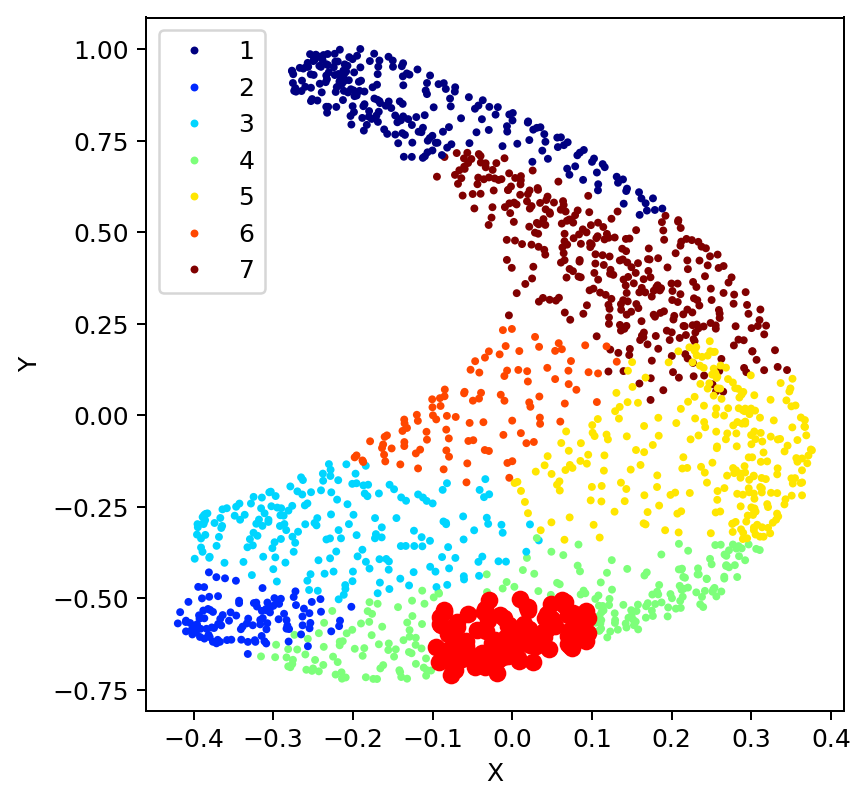

In [87]:
# generate node info matrix.
pos_h = nx.spring_layout(G_h,seed=1918) # must use the same seed.
pos_h_frame = pd.DataFrame({'pix':pos_h.keys(),'X':np.array(list(pos_h.values()))[:,0],'Y':np.array(list(pos_h.values()))[:,1]})
pos_h_frame['Community'] = louvian_df_h['community']

# you can find each pixel's location in graph,or pixel id of specific node.
print(pos_h_frame)

fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi=180)
sns.scatterplot(data=pos_h_frame,x = 'X',y='Y',hue='Community',palette=plt.cm.jet,s=10,lw=0,ax = ax)
# select specific location's pix.
sns.scatterplot(pos_h_frame[pos_h_frame['X']<0.1][pos_h_frame['Y']<-0.5][pos_h_frame['X']>-0.1],x = 'X',y='Y',color='r',s=50,lw=0,ax = ax)

___
- ##### Below will show infomap method of community discover.    
Codes below will use cdlib pkg. This pkg include multiple graph-based algorithms, most have similar data format.    

Check https://cdlib.readthedocs.io/en/latest/reference/cd_algorithms/node_clustering.html
for more info.

In [93]:
from cdlib import algorithms

infomap_l = algorithms.infomap(G_l)
infomap_h = algorithms.infomap(G_h)

# get community matrix. infomap and LPA have no overlapping, so we don't need to wash data.
infomap_l_comm = {}
for idx, community in enumerate(infomap_l.communities):
    for node in community:
        infomap_l_comm[node] = idx
infomap_h_comm = {}
for idx, community in enumerate(infomap_h.communities):
    for node in community:
        infomap_h_comm[node] = idx


infomap_l_df = pd.DataFrame({'pixel': infomap_l_comm.keys(),'community': infomap_l_comm.values()}).sort_values(by='pixel')
infomap_h_df = pd.DataFrame({'pixel': infomap_h_comm.keys(),'community': infomap_h_comm.values()}).sort_values(by='pixel')
infomap_l_df['community']+=1
infomap_h_df['community']+=1

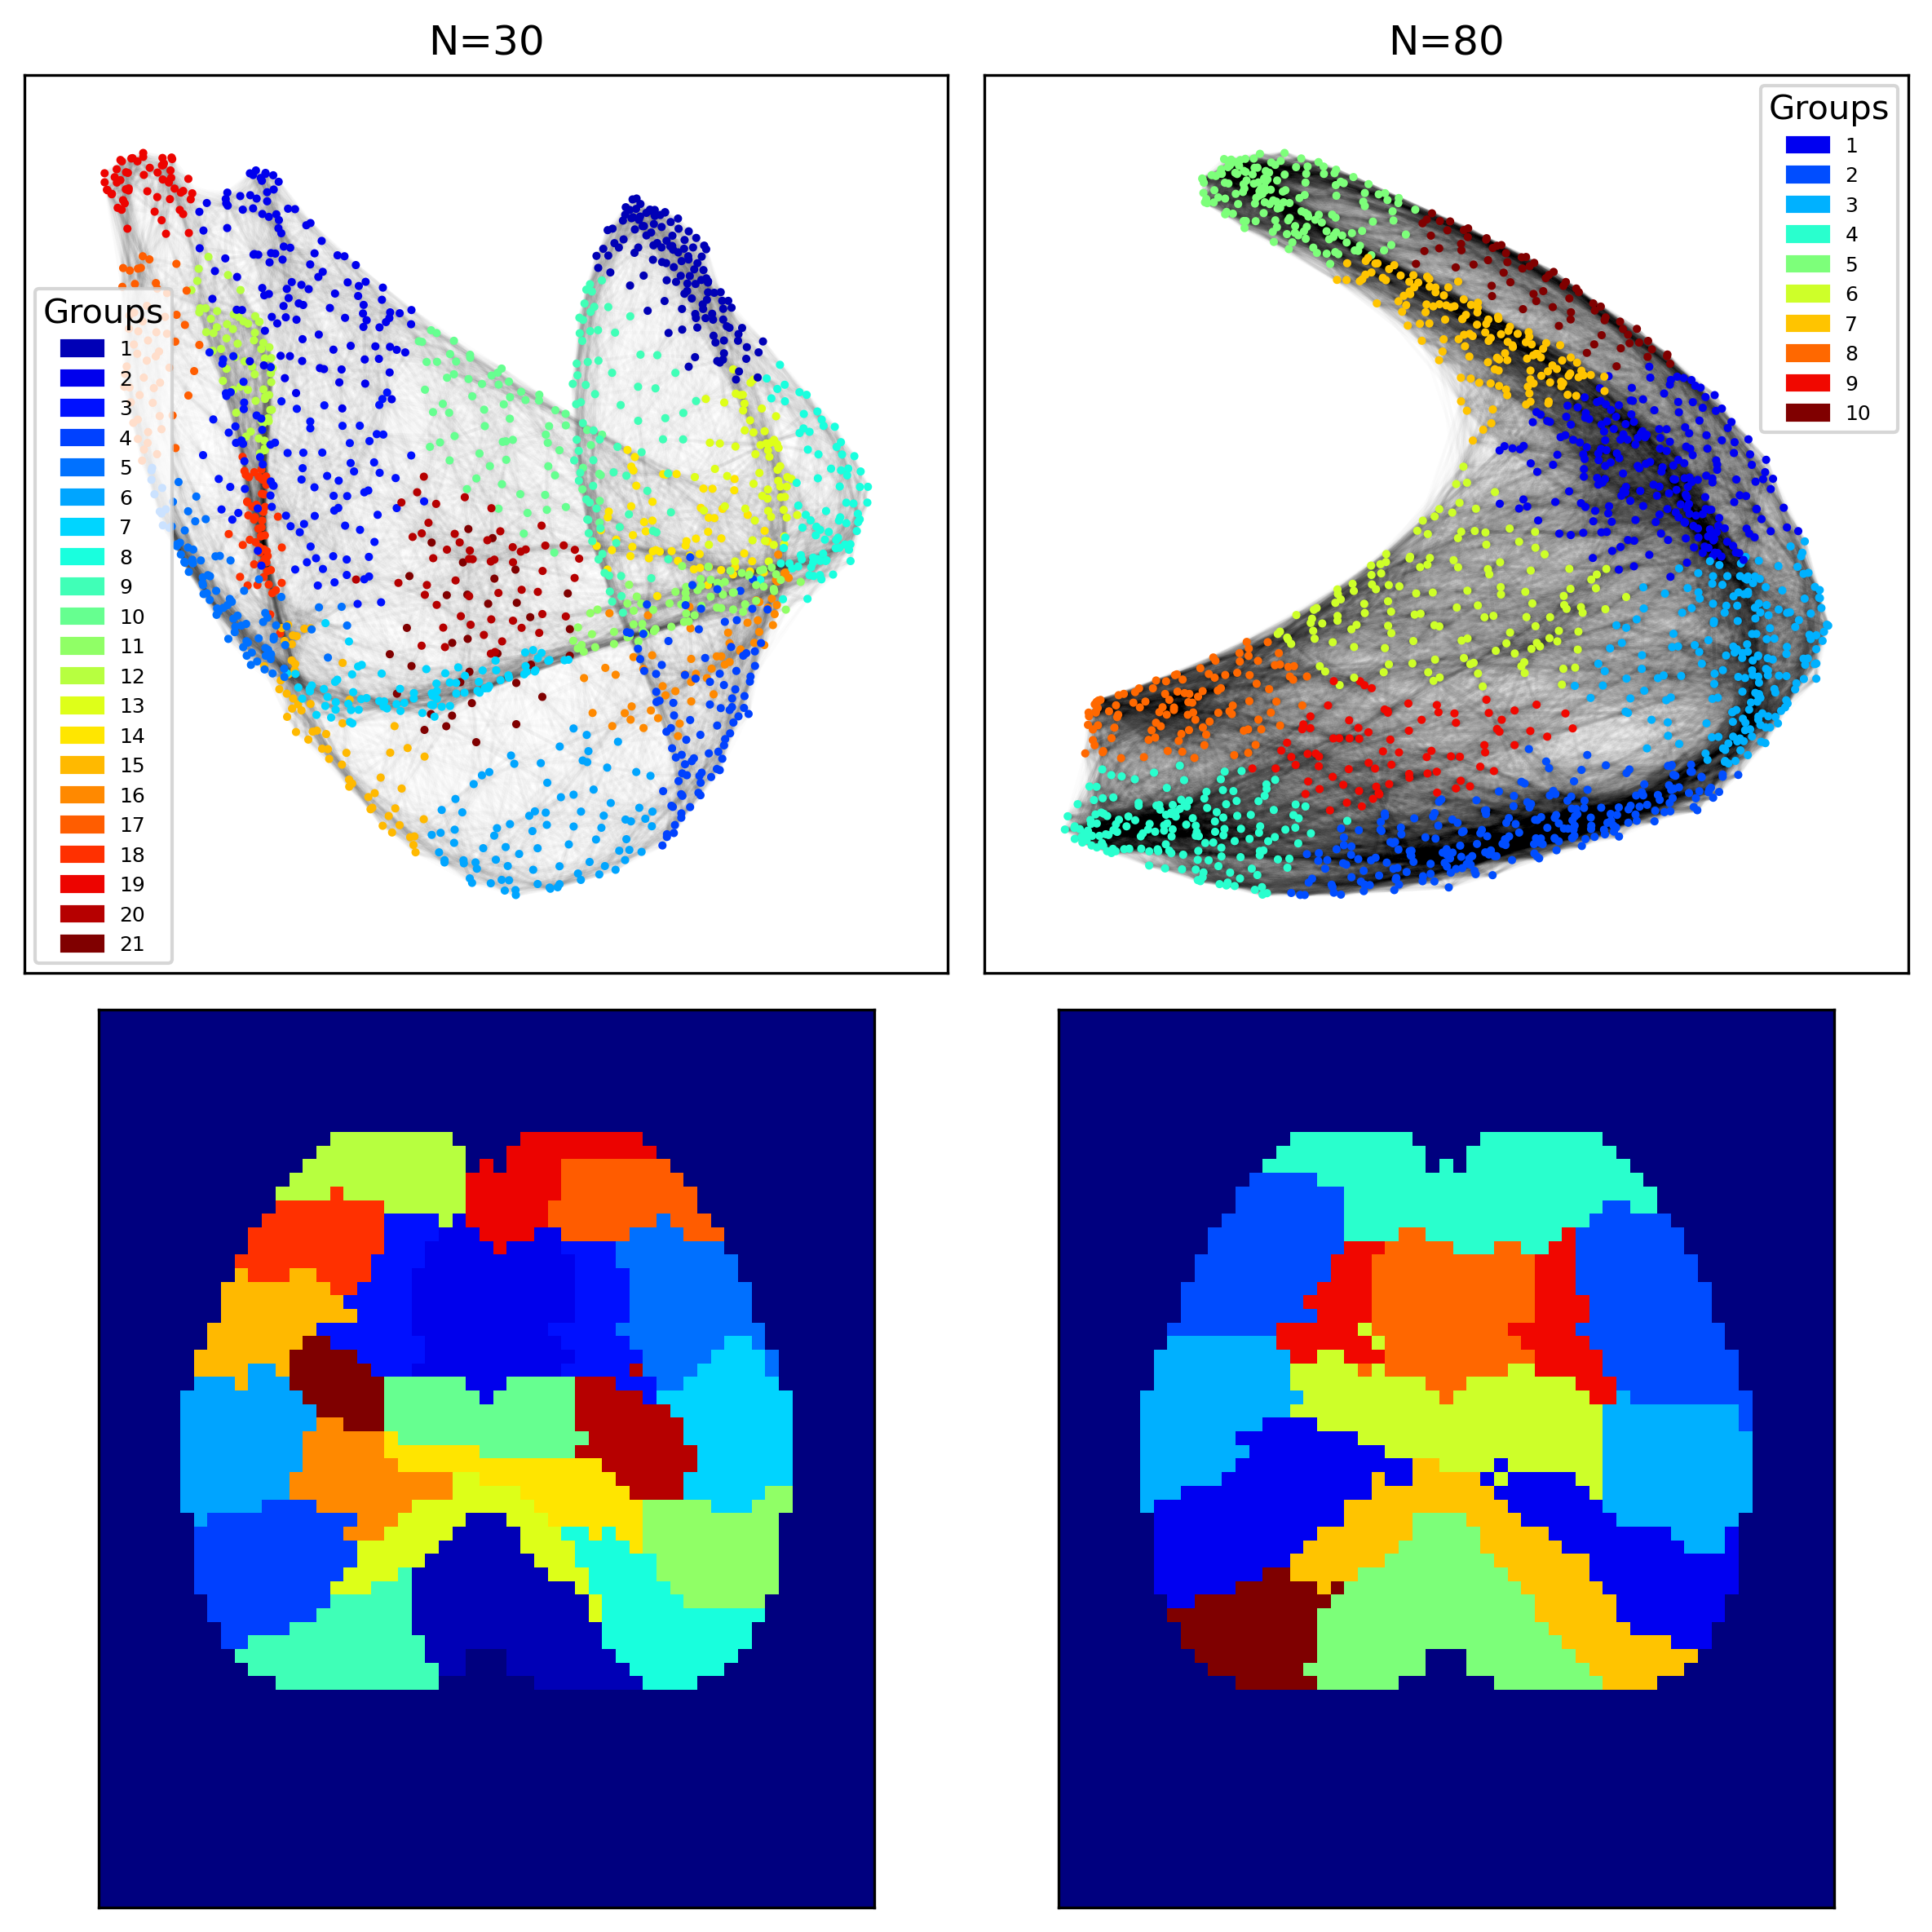

In [96]:
# plot visualization.
fig,ax = plt.subplots(ncols=2,nrows=2,figsize = (8,8),dpi = 300)
ax[0,0] = Show_Nodes(G = G_l,community_df=infomap_l_df,ax = ax[0,0],seed=1914)
ax[0,1] = Show_Nodes(G = G_h,community_df=infomap_h_df,ax = ax[0,1],seed=1918)

ax[0,0].set_title(f'N={k_l}')
ax[0,1].set_title(f'N={k_h}')

## Plot visualized graph. compare node with graph distribution.
def Recover_Community(community,on_mask):
    c_vec = community['community']
    recover = copy.deepcopy(on_mask).astype('i4')
    recover[on_mask==True] = c_vec
    return recover
recover_l = Recover_Community(infomap_l_df,on_mask)
recover_h = Recover_Community(infomap_h_df,on_mask)
# show recovered graphs below
ax[1,0].imshow(recover_l,cmap='jet')
ax[1,1].imshow(recover_h,cmap='jet')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

fig.tight_layout()

____
- ##### Another demo of Label Propagation (LPA) algorithm.
LPA concentrate only on the shape of graph, it works like a multiple seed point growing algorithm.    
Feel the difference of methods.

In [99]:
lpa_l = algorithms.label_propagation(G_l)
lpa_h = algorithms.label_propagation(G_h)

# get community matrix. infomap and LPA have no overlapping, so we don't need to wash data.
lpa_l_comm = {}
for idx, community in enumerate(lpa_l.communities):
    for node in community:
        lpa_l_comm[node] = idx
lpa_h_comm = {}
for idx, community in enumerate(lpa_h.communities):
    for node in community:
        lpa_h_comm[node] = idx


lpa_l_df = pd.DataFrame({'pixel': lpa_l_comm.keys(),'community': lpa_l_comm.values()}).sort_values(by='pixel')
lpa_h_df = pd.DataFrame({'pixel': lpa_h_comm.keys(),'community': lpa_h_comm.values()}).sort_values(by='pixel')
lpa_l_df['community']+=1
lpa_h_df['community']+=1

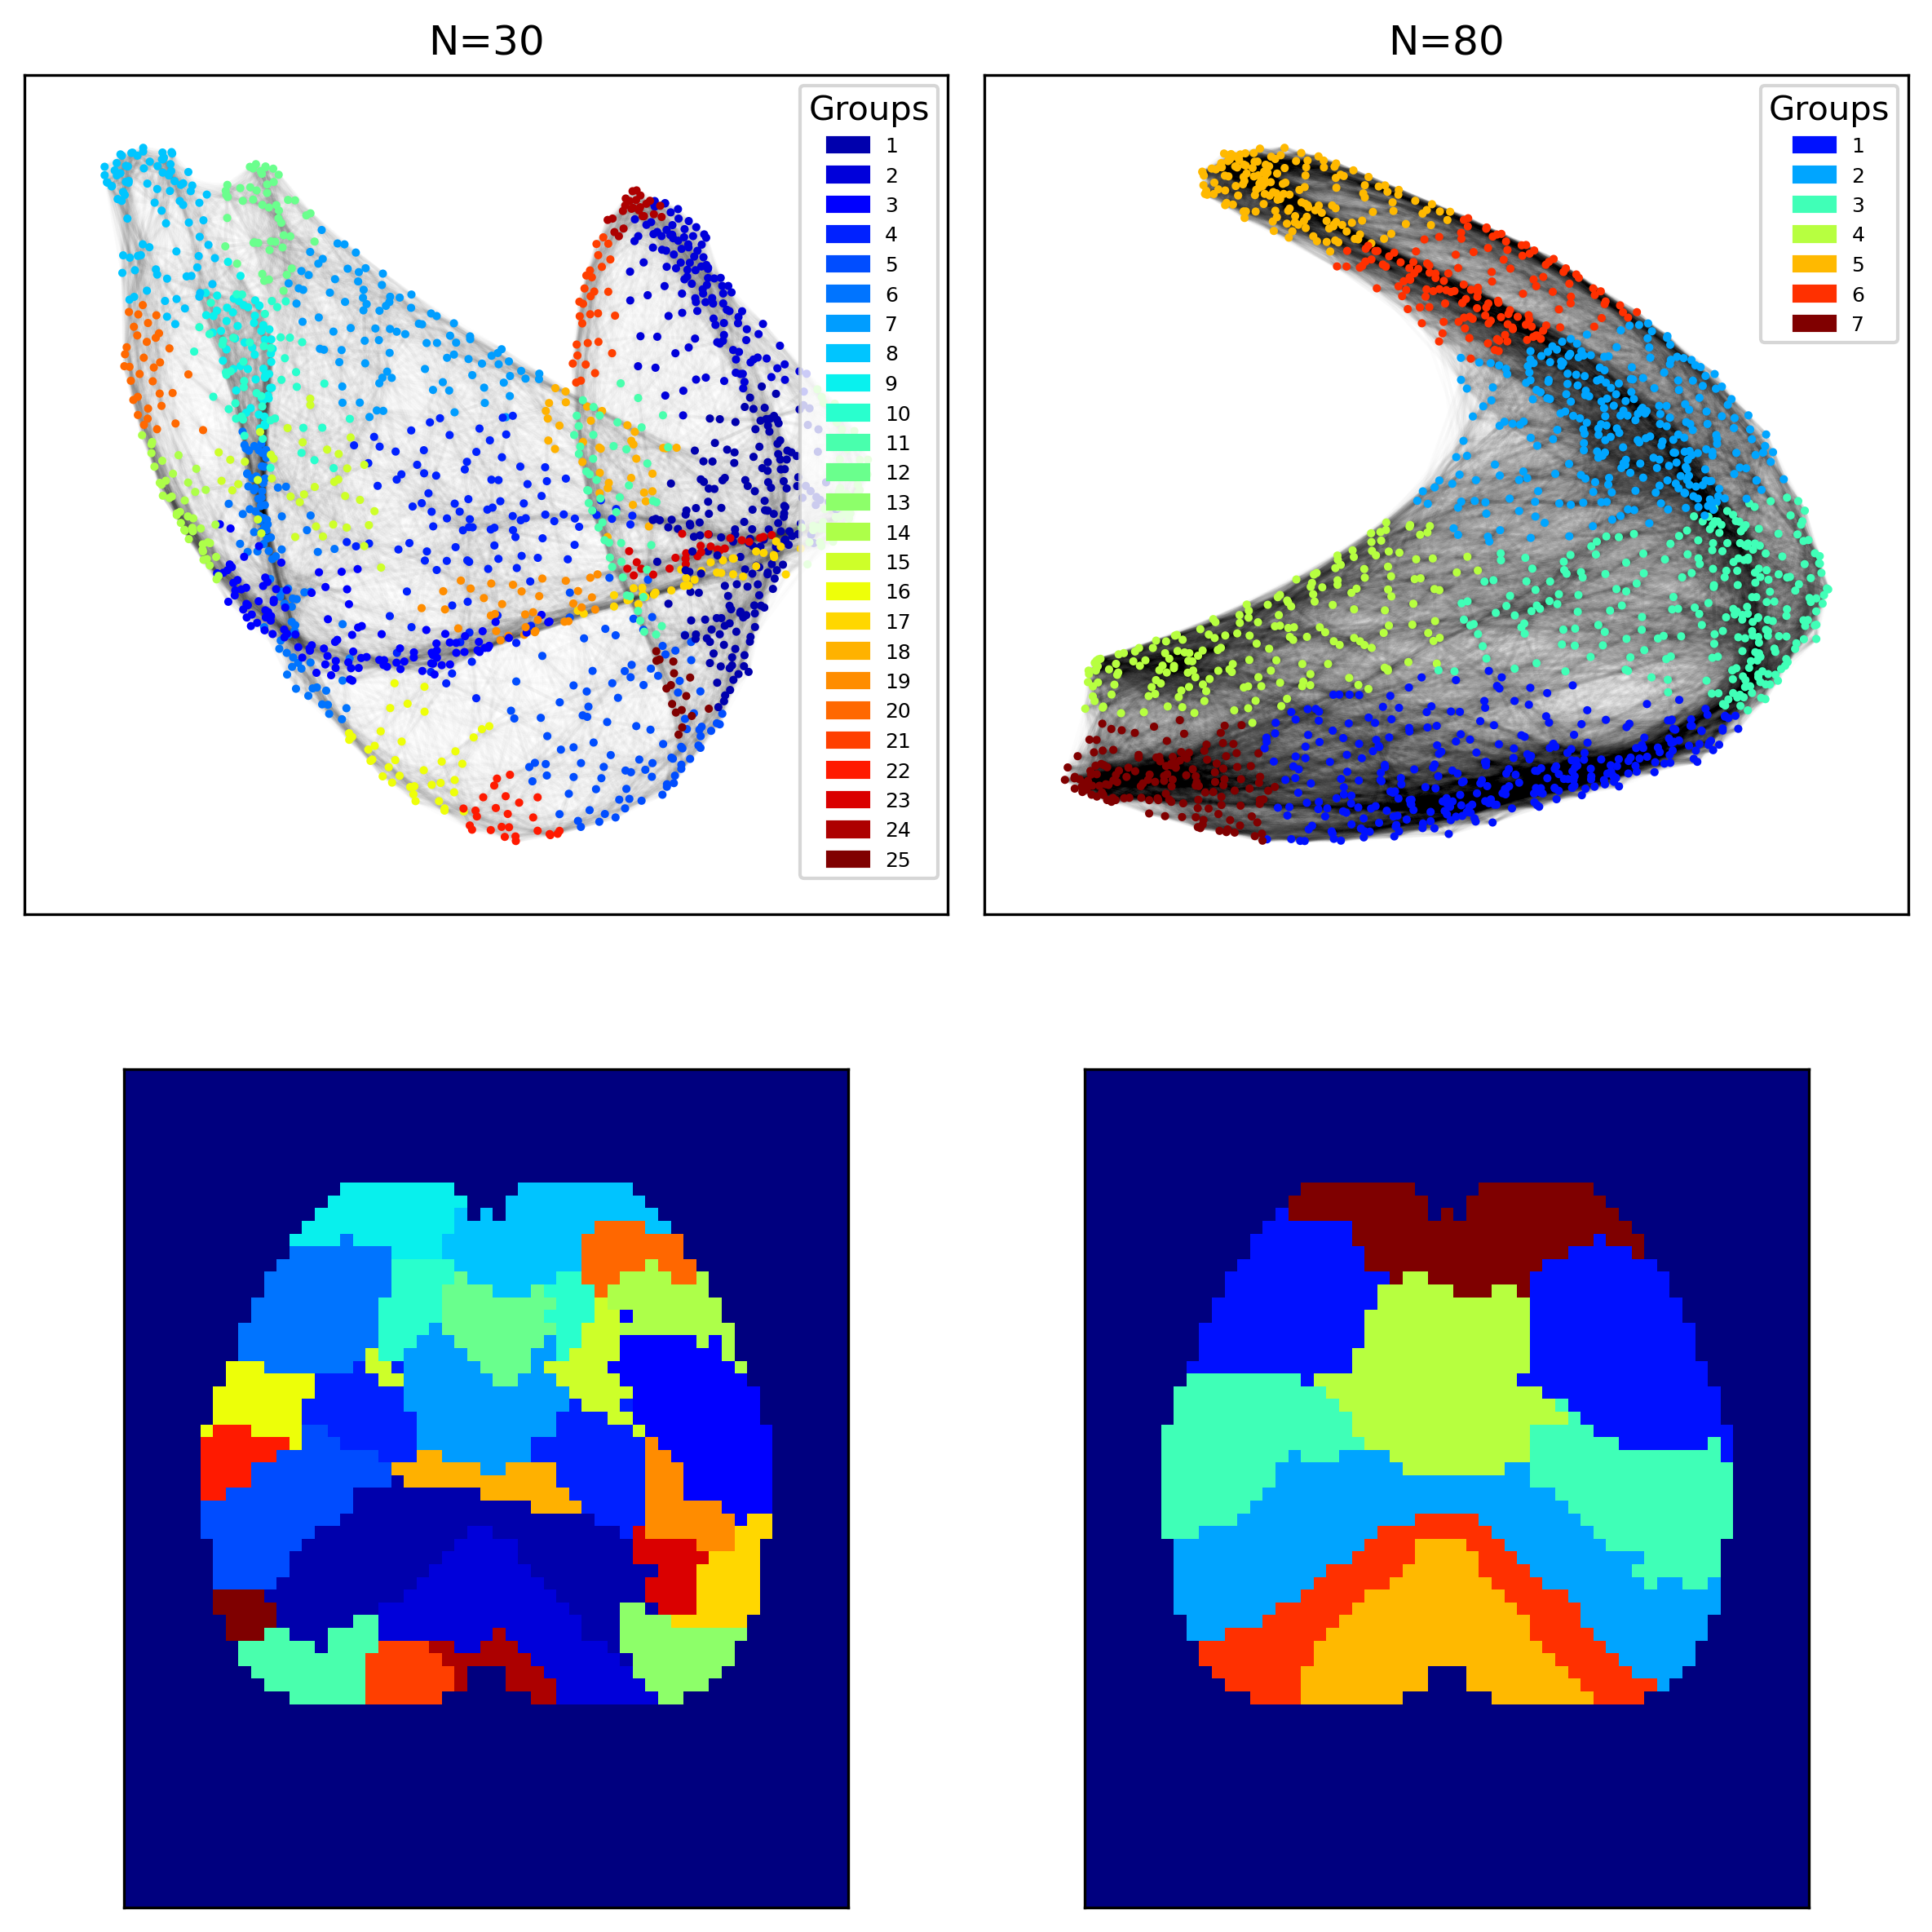

In [ ]:
# visualize LPA.
fig,ax = plt.subplots(ncols=2,nrows=2,figsize = (8,8),dpi = 300)
ax[0,0] = Show_Nodes(G = G_l,community_df=lpa_l_df,ax = ax[0,0],seed=1914)
ax[0,1] = Show_Nodes(G = G_h,community_df=lpa_h_df,ax = ax[0,1],seed=1918)

ax[0,0].set_title(f'N={k_l}')
ax[0,1].set_title(f'N={k_h}')

## Plot visualized graph. compare node with graph distribution.
def Recover_Community(community,on_mask):
    c_vec = community['community']
    recover = copy.deepcopy(on_mask).astype('i4')
    recover[on_mask==True] = c_vec
    return recover
recover_l = Recover_Community(lpa_l_df,on_mask)
recover_h = Recover_Community(lpa_h_df,on_mask)
# show recovered graphs below
ax[1,0].imshow(recover_l,cmap='jet')
ax[1,1].imshow(recover_h,cmap='jet')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

fig.tight_layout()

##### As we can see above, contralateral consistency can be found on higher k-neighbor.    
Graph method is irrevelant to pixel's physical location, so it can confirm the contralateral consistency of graph.    
Furthermore, smaller k-neibhbor have lower contra similarity, incicating the effect range of horizontal connection.

As we already put the graph into standard space, wild-type and pathology model can be compared directly.